# Week 1 Analysis Notebook

This notebook is for all the work that was done in the first week of the project. This mainly includes introductory work, getting familiar with CAESAR, FSPS, H5py and messing around with the data.

The main file being used is m25n256_151.hdf5 which is the caesar catalog from a 25 Mpc/h volume with 2x256^3 particles, at z=0

In [2]:
import h5py 
import caesar
import yt
import numpy as np
import matplotlib.pyplot as plt

import os
os.environ['SPS_HOME'] = '/home/spujni/fsps'
import fsps

In [3]:
infile = ("/home/spujni/sim/m50n512/s50/Groups/m50n512_151.hdf5")
obj = caesar.load(infile)

yt : [INFO     ] 2026-01-30 12:49:20,206 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_151.hdf5
yt : [INFO     ] 2026-01-30 12:49:20,821 Found 58101 halos
yt : [INFO     ] 2026-01-30 12:49:21,259 Found 6922 galaxies


Text(0.5, 1.0, 'Galaxy Mass Distribution')

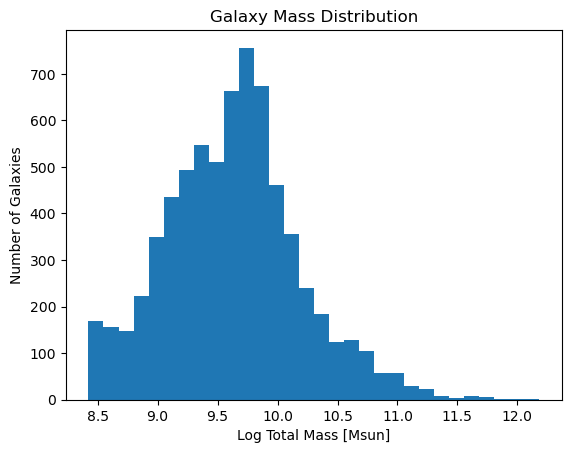

In [4]:
galaxy_masses = [i.masses['total'] for i in obj.galaxies]
plt.hist(np.log10(galaxy_masses), bins=30)
plt.xlabel('Log Total Mass [Msun]')
plt.ylabel('Number of Galaxies')
plt.title('Galaxy Mass Distribution')

In [ ]:
fsps.list_filters()

In [ ]:
#file structure
with h5py.File(infile, 'r') as f:
    def print_structure(name, obj):
        print(name)
    
    print("HDF5 File Structure:")
    f.visititems(print_structure)
    
    print("\nTop-level keys:", list(f.keys()))

Found appmag keys: ['appmag.2mass_h', 'appmag.2mass_j', 'appmag.2mass_ks', 'appmag.b', 'appmag.bessell_l', 'appmag.bessell_lp', 'appmag.bessell_m', 'appmag.buser_b', 'appmag.cfht_b', 'appmag.cfht_i', 'appmag.cfht_r', 'appmag.cousins_i', 'appmag.cousins_r', 'appmag.des_g', 'appmag.des_i', 'appmag.des_r', 'appmag.des_y', 'appmag.des_z', 'appmag.euclid_blue', 'appmag.euclid_h', 'appmag.euclid_j', 'appmag.euclid_red', 'appmag.euclid_y', 'appmag.fors_r', 'appmag.fors_v', 'appmag.galex_fuv', 'appmag.galex_nuv', 'appmag.i1500', 'appmag.i2300', 'appmag.i2800', 'appmag.irac_1', 'appmag.irac_2', 'appmag.isaac_ks', 'appmag.jwst_f070w', 'appmag.jwst_f090w', 'appmag.jwst_f115w', 'appmag.jwst_f150w', 'appmag.jwst_f200w', 'appmag.jwst_f277w', 'appmag.jwst_f356w', 'appmag.jwst_f444w', 'appmag.lsst_g', 'appmag.lsst_i', 'appmag.lsst_r', 'appmag.lsst_u', 'appmag.lsst_y', 'appmag.lsst_z', 'appmag.megacam_g', 'appmag.megacam_i', 'appmag.megacam_r', 'appmag.megacam_u', 'appmag.megacam_z', 'appmag.newfirm_h1

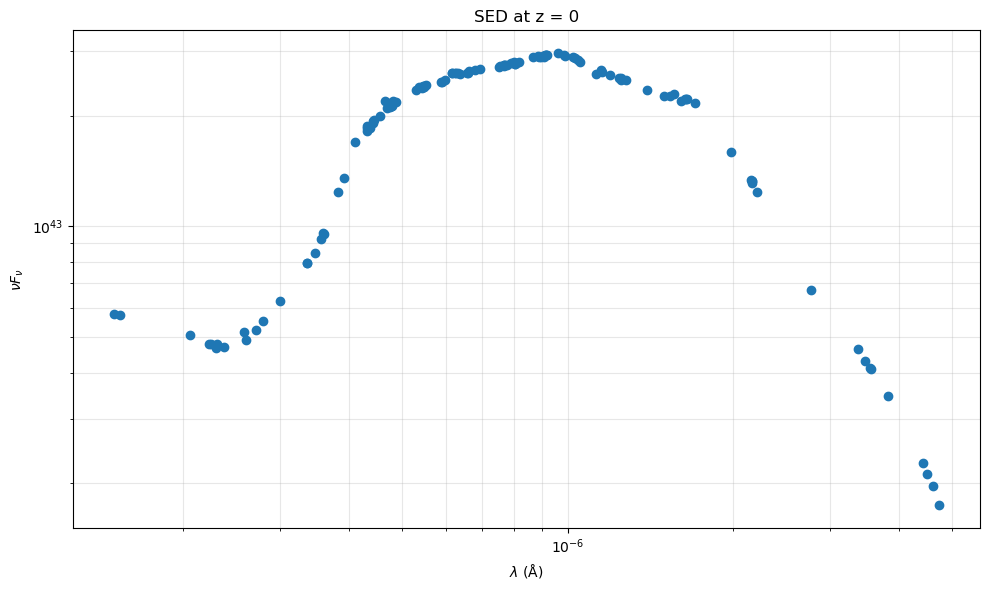

In [5]:
import astropy.units as u
from astropy.constants import c

with h5py.File(infile, 'r') as f:
    appmag_keys = [k for k in f['galaxy_data/dicts'].keys() if k.startswith('appmag.')]
    print("Found appmag keys:", appmag_keys)

    freqs = []
    fluxes = []
    labels = []

    for k in appmag_keys:
        mags = f[f'galaxy_data/dicts/{k}'][:]           # per-galaxy apparent mags (with dust)
        flux = 3631*10**(-mags / 2.5)                        # mag -> flux assuming AB
        filt = k.split('appmag.')[-1]                   

        try:
            fsps_filt = fsps.get_filter(filt)           # FSPS filter name
            wave = fsps_filt.lambda_eff * u.AA          # Angstrom
            freq = (c / wave).to(u.Hz).value            # ν = c / λ

            freqs.append(freq)
            fluxes.append(np.sum(flux))
            labels.append(filt)
        except Exception as e:
            print(f"Skipping {filt}: {e}")

freqs = np.array(freqs)
fluxes = np.array(fluxes)
labels = np.array(labels)
order = np.argsort(freqs)
freqs = freqs[order]
fluxes = fluxes[order]
labels = labels[order]
lambda_ = (c / freqs)

nu_f_nu = freqs * fluxes

plt.figure(figsize=(10, 6))
plt.loglog(lambda_, nu_f_nu, 'o', linewidth=2, markersize=6)
plt.xlabel(r'$\lambda$ (Å)')
plt.ylabel(r'$\nu F_\nu$')
plt.title('SED at z = 0')
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.show()